# Logistic regression for TrojanHorse case

## Import data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

buyer = pd.read_csv('TrojanHorse_new.csv')

In [ ]:
buyer.head()

,Gender,M,R,F,FirstPurch,BusinessExecutive,Surfer,Yuppie,Hipster,Artist,ClassicGentleman,Rugged,Formal,Casual,Comic,Success
0,1,260,16,2,18,0,0,1,0,1,0,0,0,0,0,0
1,0,259,12,5,30,1,0,1,0,0,1,1,0,0,0,0
2,1,218,16,6,42,1,1,3,1,0,0,0,0,0,0,0
3,1,143,14,1,14,0,0,0,1,0,0,0,0,0,0,0
4,1,419,8,11,52,4,0,1,0,1,1,2,1,1,1,1


In [ ]:
buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Gender             2000 non-null   int64
 1   M                  2000 non-null   int64
 2   R                  2000 non-null   int64
 3   F                  2000 non-null   int64
 4   FirstPurch         2000 non-null   int64
 5   BusinessExecutive  2000 non-null   int64
 6   Surfer             2000 non-null   int64
 7   Yuppie             2000 non-null   int64
 8   Hipster            2000 non-null   int64
 9   Artist             2000 non-null   int64
 10  ClassicGentleman   2000 non-null   int64
 11  Rugged             2000 non-null   int64
 12  Formal             2000 non-null   int64
 13  Casual             2000 non-null   int64
 14  Comic              2000 non-null   int64
 15  Success            2000 non-null   int64
dtypes: int64(16)
memory usage: 250.1 KB


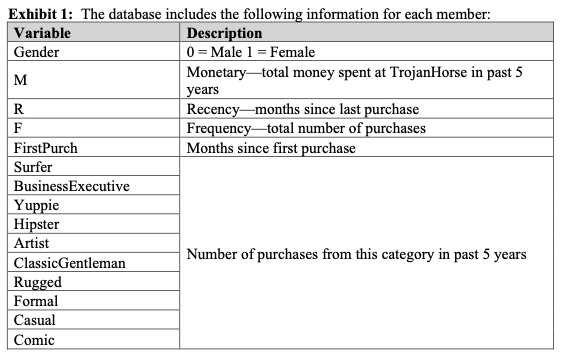

## Split data into train and test sets

*   70% training and 30% testing
*   Set seed to 528 for this case

In [ ]:
from sklearn.model_selection import train_test_split

X = buyer.drop('Success', axis=1)
y = buyer['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=528)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")



Training data shape: (1400, 15)
Testing data shape: (600, 15)


## Model 2: Selected features (X) using SequentialFeatureSelector

In [ ]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score

# Create a logistic regression model
model2 = LogisticRegression()

# Use SequentialFeatureSelector to select the best 5 features based on roc_auc
sfs = SequentialFeatureSelector(model2, n_features_to_select=5, direction='forward', scoring='roc_auc')
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[sfs.get_support()]

# Fit the model using the selected features
X_train_selected = X_train[selected_features]
model2.fit(X_train_selected, y_train)

# Add a constant to the predictor variables for statsmodels
X_train_selected_sm = sm.add_constant(X_train_selected)

# Fit the model using statsmodels
logit_model2 = sm.Logit(y_train, X_train_selected_sm)
result2 = logit_model2.fit()

# Print the summary of the model
print(result2.summary())


Optimization terminated successfully.
         Current function value: 0.276020
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Success   No. Observations:                 1400
Model:                          Logit   Df Residuals:                     1394
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.1550
Time:                        20:56:51   Log-Likelihood:                -386.43
converged:                       True   LL-Null:                       -457.31
Covariance Type:            nonrobust   LLR p-value:                 7.548e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8276      0.221     -3.742      0.000      -1.261      -0.394
Gender     



The model explains about 15% (pseudo r-square 0.15)of the variance in the dependent varialbe.

Model equation: Log(P1/P0) = -0.8276 - 0.8984 * Gender - 0.1127 * R - 0.4222 * Hipster + 0.9617 * ClassicGentleman + 0.4364 * Rugged

where:

	•	Gender (0 = Male, 1 = Female): A negative coefficient (-0.8984) indicates that being female is associated with lower odds of the outcome.
	•	R (Recency — months since last purchase): The coefficient (-0.1127) suggests that a longer time since the last purchase slightly reduces the likelihood of the outcome.
	•	Hipster (Number of purchases from this category in the past 5 years): The negative coefficient (-0.4222) indicates that more purchases in the Hipster category are associated with lower odds of the outcome.
	•	ClassicGentleman (Number of purchases from this category in the past 5 years): The positive coefficient (0.9617) suggests that more purchases in the ClassicGentleman category are associated with higher odds of the outcome.
	•	Rugged (Number of purchases from this category in the past 5 years): A positive coefficient (0.4364) implies that more purchases in the Rugged category also increase the odds of the outcome.

In summary, the model suggests that the odds of the outcome vary based on gender, recency of the last purchase, and the purchase history within certain product categories.

## Model Prediction
*   Apply model 2 to predict for test data
*   Generate the confusion matrix
*   Produce the payoff structure
*   Maximize the profit by adjusting the cutoff rate based on the business scenario

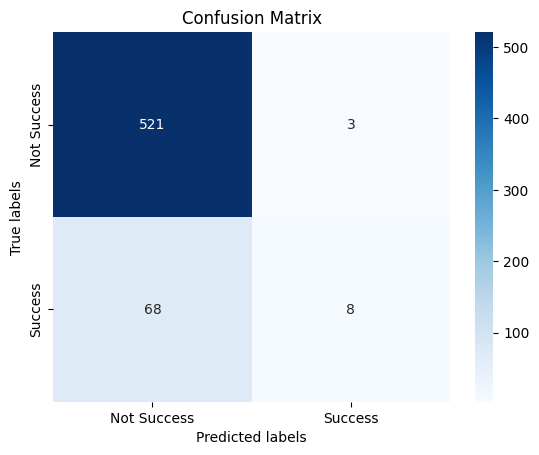

In [ ]:
# prompt: Apply testing data to make prediction and probability using model2, save a csv file as 'TrojanHorse_new_output' by concating the x testing data, y testing data, prediction, and probability. Plot a confusion matrix and swap the positions of the rows and columns of the confusion matrix.
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Apply model 2 to the test data
X_test_selected = X_test[selected_features]
y_pred_model2 = model2.predict(X_test_selected)
y_prob_model2 = model2.predict_proba(X_test_selected)[:, 1]

# Create a DataFrame with X_test, predictions, and probabilities
output_df2 = X_test.copy()
output_df2['Prediction'] = y_pred_model2
output_df2['Probability'] = y_prob_model2
output_df2['Actual'] = y_test

# Save the DataFrame to a CSV file
output_df2.to_csv('testoutput.csv', index=False)


# Generate the confusion matrix
def plot_confusion_matrix(y,y_predict, title):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Success', 'Success'],
            yticklabels=['Not Success', 'Success']); #annot=True to annotate cells
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title);
    plt.show()

plot_confusion_matrix(y_test,y_pred_model2, 'Confusion Matrix')


**Produce the payoff structure**

In [ ]:


# Calculate the prediction rate
true_positives = ((output_df2['Actual'] == 1) & (output_df2['Prediction'] == 1)).sum()
false_positives = ((output_df2['Actual'] == 0) & (output_df2['Prediction'] == 1)).sum()
predicted_successes = (output_df2['Prediction'] == 1).sum()

if predicted_successes > 0:
  prediction_rate = true_positives / predicted_successes
else:
  prediction_rate = 0  # Avoid division by zero
print(f"Prediction Rate: {prediction_rate}")

# Calculate the actual payoff by applying this model to the business scenario.

# Profit per product after mailing cost (true prediction)
profit_true = 45.5

# Cost of Mailing the product to not a buyer (false prediction)
loss_false = -4

# Predicted number of successful purchases
predicted_purchases = true_positives

# Predicted number of returns (false predictions)
predicted_returns = false_positives

# Calculate the predicted profit
predicted_profit = predicted_purchases * profit_true + predicted_returns * loss_false

# Create a table to visualize the results
results_table = pd.DataFrame({
    'Metric': ['Predicted Profit', 'Number of Purchases (True)', 'Number of Returns (False)'],
    'Value': [predicted_profit, predicted_purchases, predicted_returns]
})

print(f'Actual Profit Table \n{results_table}')


Prediction Rate: 0.7272727272727273
Actual Profit Table 
                       Metric  Value
0            Predicted Profit  352.0
1  Number of Purchases (True)    8.0
2   Number of Returns (False)    3.0


**Conclusion:**


*   Although the model achieved a high prediction accuracy of around 72%, its practical business impact remains limited, yielding a profit of only $352, which is due to the model’s tendency to reject a large proportion of customers once we consider the payoff results within the business context.
*   To address this, we have decided to adjust the cutoff rate to align with the average success rate. This change aims to balance prediction accuracy with a more favorable acceptance rate, improving profitability by relaxing the model’s overly stringent rejection criteria.


# Maximize the profit by adjusting the cutoff rate based on the business scenario

In [ ]:
output_df2.columns

Index(['Gender', 'M', 'R', 'F', 'FirstPurch', 'BusinessExecutive', 'Surfer',
       'Yuppie', 'Hipster', 'Artist', 'ClassicGentleman', 'Rugged', 'Formal',
       'Casual', 'Comic', 'Prediction', 'Probability', 'Actual'],
      dtype='object')

We use average probability of success as a cutoff rate to determine whether to predict success or not.

In [ ]:
average_prob = output_df2['Probability'].mean()
print(average_prob)

output_df2['Most Likely Success'] = [1 if i > average_prob else 0 for i in output_df2['Probability']]


0.1012140260648252


Plot the confusion matrix as a heatmap with swapped labels

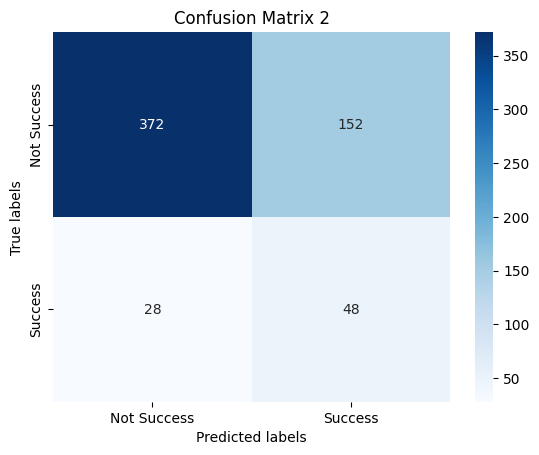

In [ ]:
plot_confusion_matrix(output_df2['Actual'],output_df2['Most Likely Success'], 'Confusion Matrix 2')

Calculate the payoff structure after adjusting the cutoff rate

In [ ]:
# Calculate the prediction rate
true_positives = ((output_df2['Actual'] == 1) & (output_df2['Most Likely Success'] == 1)).sum()
false_positives = ((output_df2['Actual'] == 0) & (output_df2['Most Likely Success'] == 1)).sum()
predicted_successes = (output_df2['Most Likely Success'] == 1).sum()

if predicted_successes > 0:
  prediction_rate = true_positives / predicted_successes
else:
  prediction_rate = 0  # Avoid division by zero
print(f"Prediction Rate: {prediction_rate}")

# Calculate the actual payoff by applying this model to the business scenario.

# Profit per product after mailing cost (true prediction)
profit_true = 45.5

# Cost of Mailing the product to not a buyer (false prediction)
loss_false = -4

# Predicted number of successful purchases
predicted_purchases = true_positives

# Predicted number of returns (false predictions)
predicted_returns = false_positives

# Calculate the predicted profit
predicted_profit = predicted_purchases * profit_true + predicted_returns * loss_false

# Create a table to visualize the results
results_table = pd.DataFrame({
    'Metric': ['Predicted Profit', 'Number of Purchases (True)', 'Number of Returns (False)'],
    'Value': [predicted_profit, predicted_purchases, predicted_returns]
})

print(f'Actual Profit Table \n{results_table}')

Prediction Rate: 0.24
Actual Profit Table 
                       Metric   Value
0            Predicted Profit  1576.0
1  Number of Purchases (True)    48.0
2   Number of Returns (False)   152.0


After adjusting the cutoff rate, the model’s prediction accuracy decreased to 24%. However, this change led to a significant increase in predicted profit, which rose to $1,576—an improvement of approximately 347.7%

Given the prediction rate above, if the profit of true prediction is 45.5 and the loss of false prediction is -4. We apply this into our case of selecting 50000 customers.

In [ ]:
# Number of customers selected
n_customers = 50000

# Profit per true prediction
profit_true = 45.5

# Loss per false prediction
loss_false = -4

# Predicted number of successful purchases
predicted_purchases = int(n_customers * prediction_rate)

# Predicted number of returns (false predictions)
predicted_returns = n_customers - predicted_purchases

# Calculate the predicted profit
predicted_profit = predicted_purchases * profit_true + predicted_returns * loss_false

# Create a table to visualize the results
results_table = pd.DataFrame({
    'Metric': ['Predicted Profit', 'Number of Purchases (True)', 'Number of Returns (False)'],
    'Value': [predicted_profit, predicted_purchases, predicted_returns]
})

print(results_table)


                       Metric     Value
0            Predicted Profit  394000.0
1  Number of Purchases (True)   12000.0
2   Number of Returns (False)   38000.0


\
\begin{array}{|c|c|}
\hline
\text{Metric} & \text{Value} \\
\hline
\text{Total Predicted Profit} & 394,000 \\
\text{Number of Purchases (True)} & 12,000 \\
\text{Number of Returns (False)} & 38,000 \\
\hline
\end{array}


In [22]:
output_df2.to_csv('log_testing_prediction.csv', index=False)

# *Project Conclusion*

1.   Statistical Interpretation of the Model: The model explains about 15% (pseudo r-square 0.15)of the variance in the dependent variable.

*  SequentialFeatureSelector: We used this technique to select the best 5 features based on roc_auc and forward selection.

*   Model equation: Log(P1/P0) = -0.8276 - 0.8984 * Gender - 0.1127 * R - 0.4222*Hipster + 0.9617 * ClassicGentleman + 0.4364 * Rugged

*   Gender (0 = Male, 1 = Female): A negative coefficient (-0.8984) indicates
that being female is associated with lower odds of the outcome.

*   Recency (R) has a negative coefficient (-0.1127), indicating that customers who made a purchase more recently are more likely to be profitable. This reflects a common trend in customer behavior, where more recent interactions often signal higher engagement and future purchasing likelihood.

*   The Hipster segment (Hipster), with a negative coefficient (-0.4222), is associated with reduced profitability, suggesting that this group may not be as valuable to the business.

*   In contrast, the ClassicGentleman (0.9617) and Rugged (0.4364) segments have positive coefficients, indicating that customers with a higher number of purchases in these categories are more profitable.


---


2.   Importance of Analyzing Model Prediction:

*	While the model initially achieved a high prediction accuracy of 72%, this did not lead to strong business results, as the model’s strict cutoff rate rejected most customers, leading to a minimal profit of $352.

*	This illustrates that high predictive accuracy alone doesn’t guarantee a successful model for business, especially if the model’s decisions do not align with profitability goals.


---


3. Applying the Model in a Business Scenario:
*	By adjusting the cutoff rate to match the average success rate, although this adjustment reduced prediction accuracy to 24%, we were able to significantly improve predicted profitability, increasing it to $1,576—an improvement of 347.7% over the original model, aligning better with business objectives.

*	We utilized this model with the prediction accuracy of 24% to select 50,000 potential buyers and predict the potential outcomes:



> 1. The predicted # of purchase would be 12,000
> 2. The predicted # of return would be 38,000 -
> 3. The predicted profit would be  $394,000, which is an around 410% increase compared to the baseline profit of 77,200 if the products are mailed randomly.



